## Deep Learning: Estimacion de parametros antropometricos

El sistema consistirá en detectar las medidas antropometricas de un paciente a partir de una foto para estimar el nivel de trofia muscular y posteriormente establecer los parametros de la rutina de reahbilitación

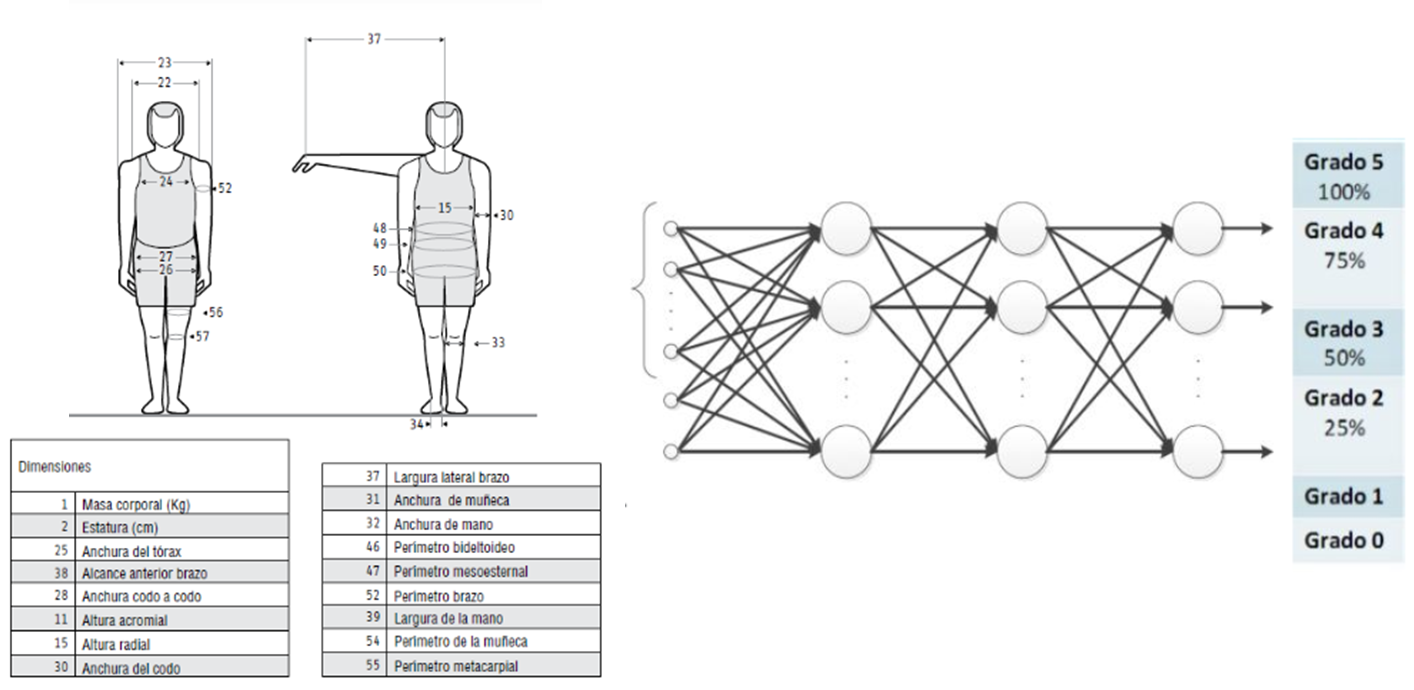

### Arquitectura del sistema completo

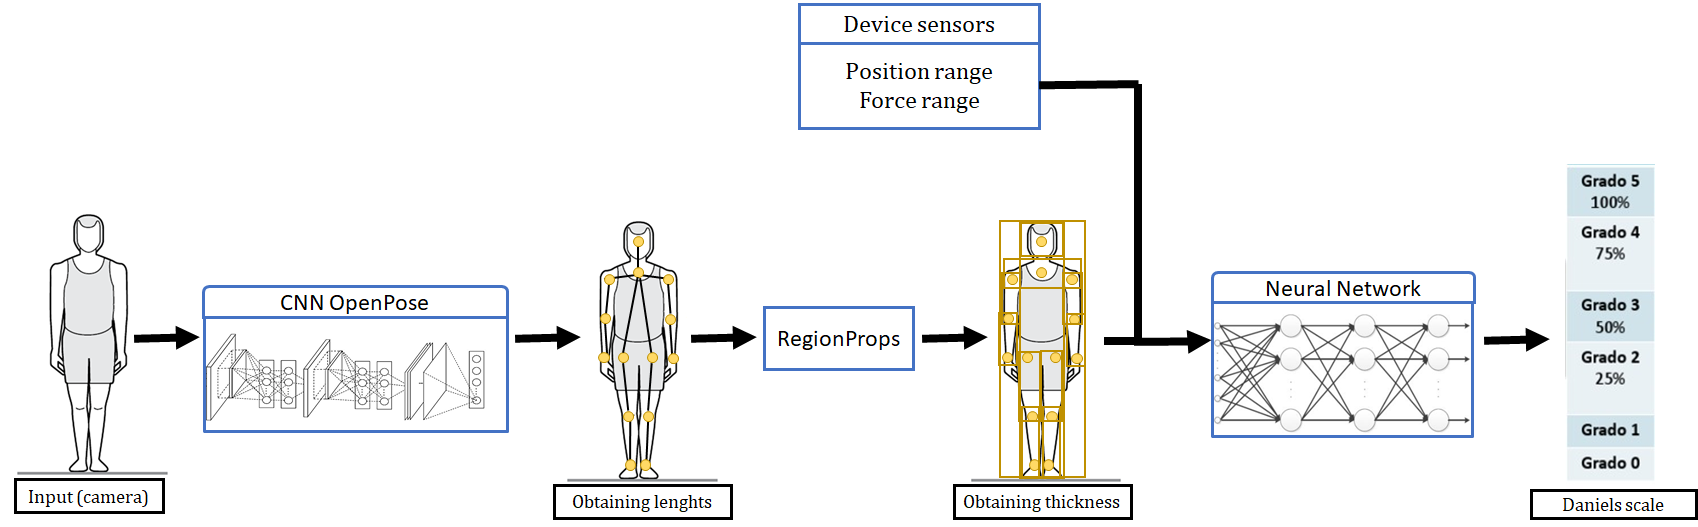

## Implementación del sistema 

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Mostrar el resultado de cada linea de la misma celda

# importar librerias 
import numpy as np
import pandas as pd
import tensorflow
import keras
import cv2
import os
from pycocotools.coco import COCO
import pycocotools.mask as mask_util
from random import randint
import json
import math

#importar caracteristicas de librerias
from matplotlib import colors
from keras.layers import Dense
from keras.models import Sequential, load_model 
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import scale, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, ElasticNet
from skimage import filters, feature, measure, morphology, segmentation, color
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import rgb2gray, label2rgb
from scipy.ndimage import distance_transform_edt
from Postprocess import*
from RBFN import*

from keras.regularizers import l2, l1, l1_l2
from keras.layers import Dropout
from keras import backend as K
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas import DataFrame
import time
import random

%matplotlib inline

Using TensorFlow backend.


In [2]:
# seleccion del modo de procesamiento

MODE = "COCO"

if MODE is "COCO":
    protoFile = "coco/pose_deploy_linevec.prototxt"
    weightsFile = "coco/pose_iter_440000.caffemodel"
    nPoints = 14
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

elif MODE is "MPI" :
    protoFile = "mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]


In [3]:
frame = cv2.imread("test4.jpg")
frameCopy = np.copy(frame)
frameOriginal = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [4]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

t = time.time()
# input image dimensions for the network
inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
print("time taken by network : {:.3f}".format(time.time() - t))

time taken by network : 18.008


In [5]:
H = output.shape[2]
W = output.shape[3]

# Empty list to store the detected keypoints
my_points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_PLAIN, 1.2, (255, 255, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        my_points.append((int(x), int(y)))
    else :
        my_points.append(None)        

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

In [6]:
i=0
dist=[]
pmid=[]

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if my_points[partA] and my_points[partB]:
        
        p1 = my_points[partA]
        p2 = my_points[partB]
        
        d = np.sqrt(np.power(p2[0]-p1[0],2) + np.power(p2[1]-p1[1],2)) 
        pmean = [(p1[0]+p2[0])/2 , (p1[1]+p2[1])/2]
        
        cv2.line(frame, my_points[partA], my_points[partB], (0, 255, 255), 2)
        cv2.circle(frame, my_points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
        
        if (partA<=14 and partB<=14):
            cv2.putText(frame, "{}".format(int(d)), (int(pmean[0]), int(pmean[1])), cv2.FONT_HERSHEY_PLAIN, 1.2, (255, 255, 255), 2, lineType=cv2.LINE_AA)
            dist.append((int(d), int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1]),int(partA),int(partB)))
            pmid.append((int(pmean[0]),int(pmean[1])))
            
    i = i + 1
dist = np.array(dist)
pmid = np.array(pmid)
points=np.array(my_points)

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

array([[[238, 173,  58],
        [238, 173,  58],
        [238, 173,  58],
        ...,
        [233, 175,  72],
        [233, 175,  72],
        [233, 175,  72]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [234, 176,  73],
        [234, 176,  73],
        [234, 176,  73]],

       [[239, 174,  59],
        [239, 174,  59],
        [239, 174,  59],
        ...,
        [235, 177,  74],
        [235, 177,  74],
        [235, 177,  74]],

       ...,

       [[195, 198, 176],
        [191, 194, 172],
        [184, 187, 165],
        ...,
        [121, 129, 119],
        [166, 172, 161],
        [226, 232, 221]],

       [[223, 231, 214],
        [222, 232, 215],
        [222, 232, 215],
        ...,
        [178, 186, 175],
        [207, 211, 199],
        [194, 198, 186]],

       [[201, 211, 198],
        [199, 209, 196],
        [195, 208, 194],
        ...,
        [185, 193, 182],
        [186, 190, 178],
        [116, 120, 108]]

Text(0.5, 1.0, 'Joints detection')

Text(0.5, 1.0, 'Connecting the points')

-1

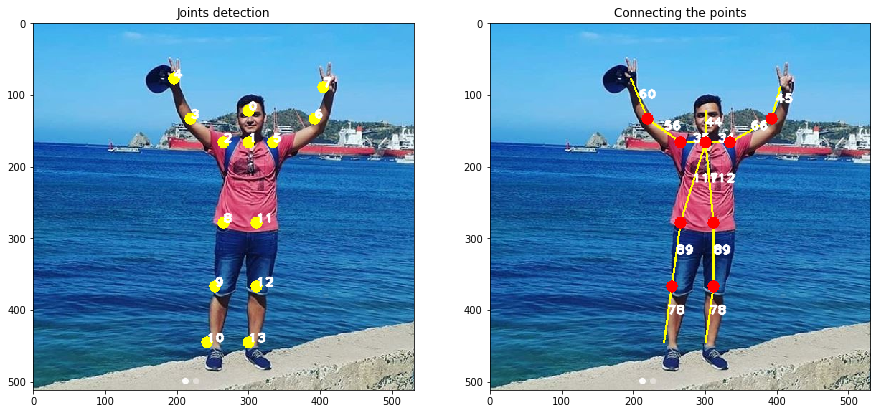

In [7]:
fig = plt.figure(figsize=(15,10))

a = fig.add_subplot(1, 2, 1)
#im1 = cv2.resize(frameCopy, (1000, 1000)) 
imgplot = plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
a.set_title('Joints detection')

a = fig.add_subplot(1, 2, 2)
#im2 = cv2.resize(frame, (1000, 1000))
imgplot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
a.set_title('Connecting the points')

cv2.waitKey(0)

In [8]:
points
dist
dist[:,1:3]

array([[300, 122],
       [300, 166],
       [265, 166],
       [219, 133],
       [196,  77],
       [334, 166],
       [392, 133],
       [404,  89],
       [265, 278],
       [253, 367],
       [242, 445],
       [311, 278],
       [311, 367],
       [300, 445]])

array([[ 44, 300, 166, 300, 122,   1,   0],
       [ 35, 300, 166, 265, 166,   1,   2],
       [ 34, 300, 166, 334, 166,   1,   5],
       [ 56, 265, 166, 219, 133,   2,   3],
       [ 60, 219, 133, 196,  77,   3,   4],
       [ 66, 334, 166, 392, 133,   5,   6],
       [ 45, 392, 133, 404,  89,   6,   7],
       [117, 300, 166, 265, 278,   1,   8],
       [ 89, 265, 278, 253, 367,   8,   9],
       [ 78, 253, 367, 242, 445,   9,  10],
       [112, 300, 166, 311, 278,   1,  11],
       [ 89, 311, 278, 311, 367,  11,  12],
       [ 78, 311, 367, 300, 445,  12,  13]])

array([[300, 166],
       [300, 166],
       [300, 166],
       [265, 166],
       [219, 133],
       [334, 166],
       [392, 133],
       [300, 166],
       [265, 278],
       [253, 367],
       [300, 166],
       [311, 278],
       [311, 367]])

In [9]:
model = load_model('models/unet_no_drop.h5')

<Figure size 720x720 with 0 Axes>

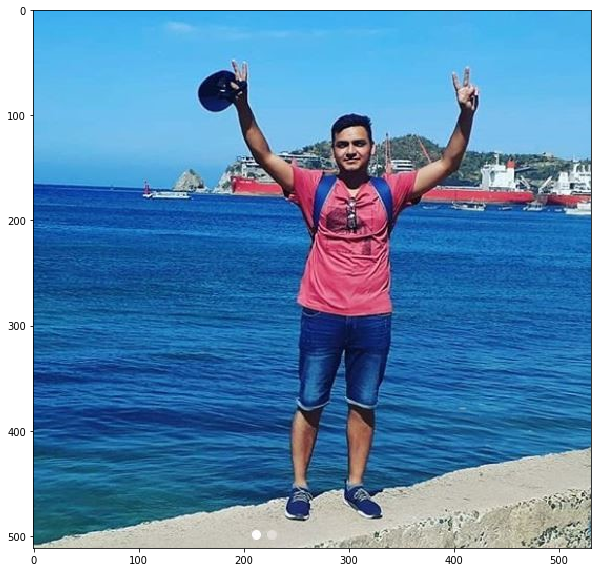

In [10]:
img = frameOriginal
img_ori = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
img_ori2 = img_ori.copy()

plt.figure(figsize=(10, 10))
plt.imshow(img_ori)

<Figure size 576x576 with 0 Axes>

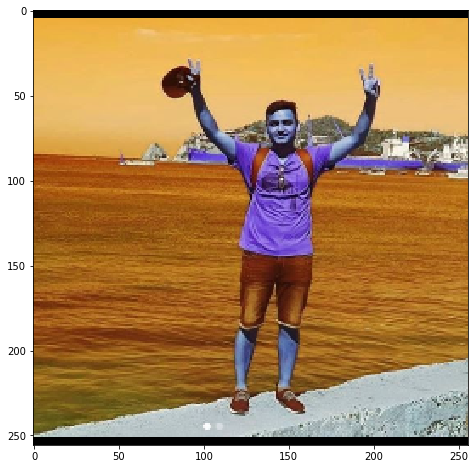

In [11]:
IMG_WIDTH, IMG_HEIGHT = 256, 256

def preprocess(img):
    im = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)
    
    if img.shape[0] >= img.shape[1]:
        scale = img.shape[0] / IMG_HEIGHT
        new_width = int(img.shape[1] / scale)
        diff = (IMG_WIDTH - new_width) // 2
        img = cv2.resize(img, (new_width, IMG_HEIGHT))

        im[:, diff:diff + new_width, :] = img
    else:
        scale = img.shape[1] / IMG_WIDTH
        new_height = int(img.shape[0] / scale)
        diff = (IMG_HEIGHT - new_height) // 2
        img = cv2.resize(img, (IMG_WIDTH, new_height))

        im[diff:diff + new_height, :, :] = img
        
    return im

img = preprocess(img)

plt.figure(figsize=(8, 8))
plt.imshow(img)

<Figure size 576x576 with 0 Axes>

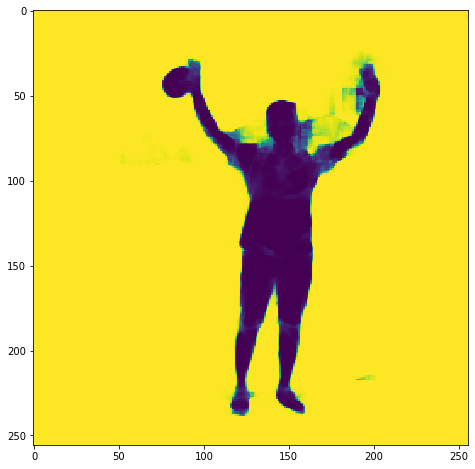

In [12]:
input_img = img.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3)).astype(np.float32) / 255.

pred = model.predict(input_img)
plt.figure(figsize=(8, 8))
plt.imshow(pred[0,:,:,0])

In [13]:
pred[0,0,2]

array([1.0000000e+00, 1.3351809e-29], dtype=float32)

<Figure size 1152x1152 with 0 Axes>

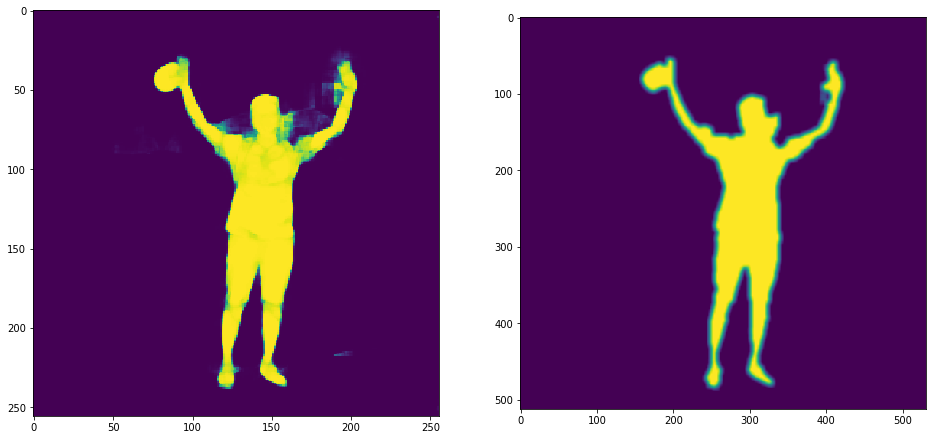

In [14]:
THRESHOLD = 0.5
EROSION = 1

mask = postprocess(img_ori, pred, THRESHOLD, EROSION)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(mask)

<Figure size 720x720 with 0 Axes>

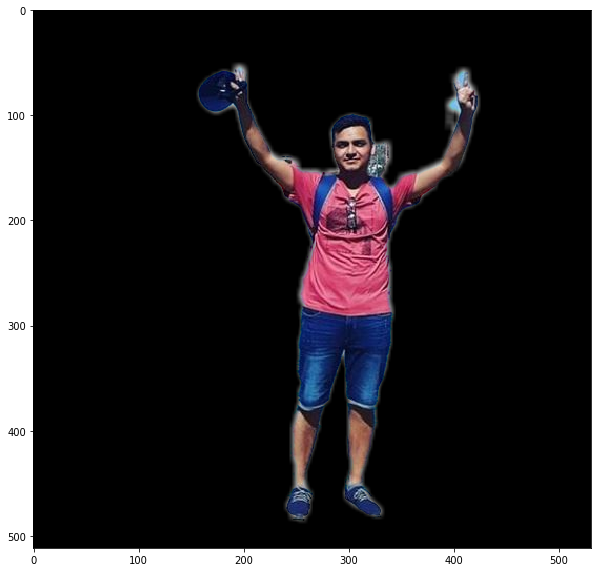

In [15]:
converted_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

result_img = cv2.subtract(converted_mask, img_ori)
result_img = cv2.subtract(converted_mask, result_img)

plt.figure(figsize=(10, 10))
plt.imshow(result_img)
#plt.imshow(converted_mask)

<Figure size 576x576 with 0 Axes>

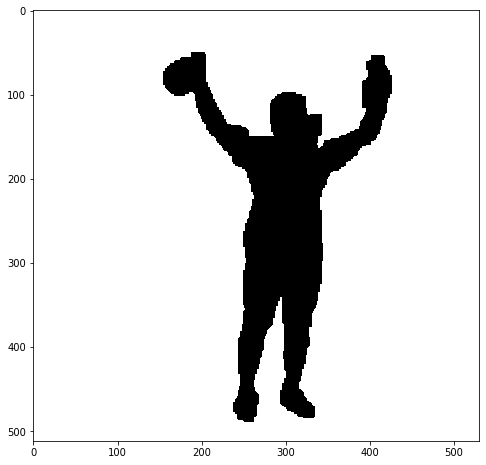

In [16]:
# convert to grayscale
gray = cv2.cvtColor(result_img, cv2.COLOR_RGB2GRAY)
# create a binary thresholded image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(8, 8))
plt.imshow(binary, cmap="gray")
plt.show()

<Figure size 1080x720 with 0 Axes>

(<matplotlib.axes._subplots.AxesSubplot at 0x132c22bd808>,
 Text(0.5, 1.0, 'Filtro Blur'))

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

(<matplotlib.axes._subplots.AxesSubplot at 0x132cbbf3688>,
 Text(0.5, 1.0, 'Filtro denoise'))

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

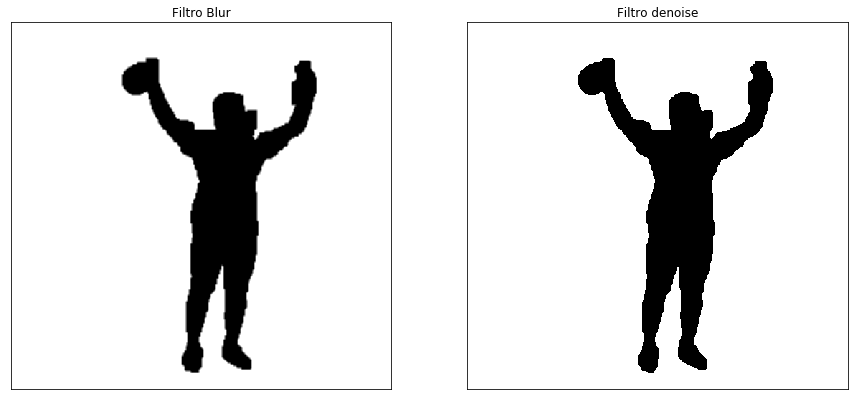

In [17]:
blur = cv2.blur(binary,(3,3))
denoised = filters.median(binary,selem=np.ones((5,5)))

plt.figure(figsize=(15,10))
plt.subplot(121),plt.imshow(blur, cmap="gray"),plt.title('Filtro Blur')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(denoised, cmap="gray"),plt.title('Filtro denoise')
plt.xticks([]), plt.yticks([])
plt.show()

<Figure size 576x576 with 0 Axes>

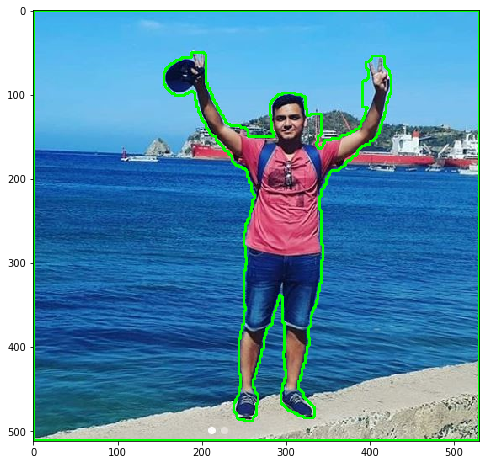

In [18]:
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(img_ori, contours, -1, (0, 255, 0), 2)
# show the image with the drawn contours
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

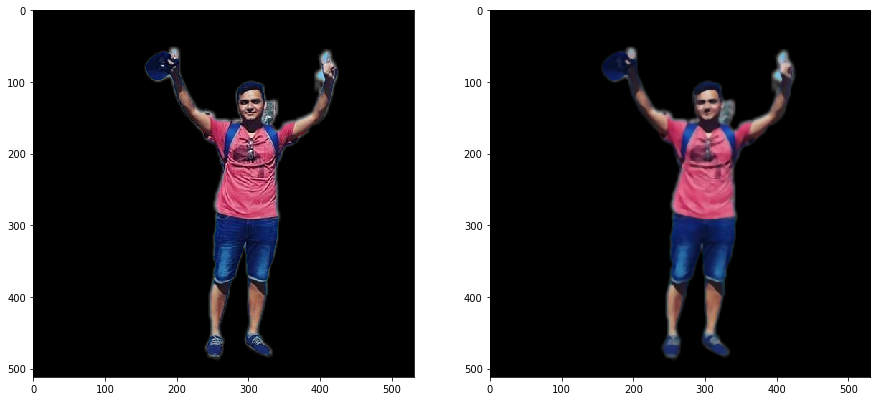

In [19]:
image_denoised = filters.median(result_img,selem=np.ones((5,5,1)))

f,(ax0,ax1) = plt.subplots(1,2, figsize=(15,10))
ax0.imshow(result_img)
ax1.imshow(image_denoised);

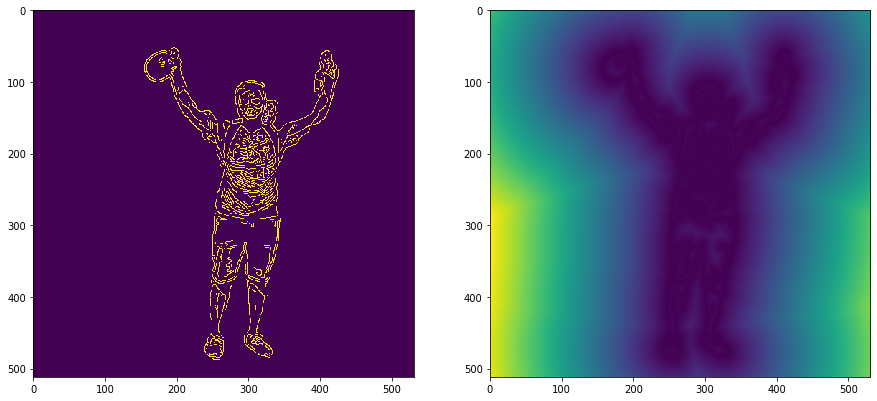

In [20]:
edges = feature.canny(result_img[:,:,0], sigma=1)
dt = distance_transform_edt(~edges)

f,(ax0,ax1) = plt.subplots(1,2, figsize=(15,10))
ax0.imshow(edges)
ax1.imshow(dt)

array([[473, 318],
       [473, 317],
       [473, 254],
       [473, 253],
       [473, 252]], dtype=int64)

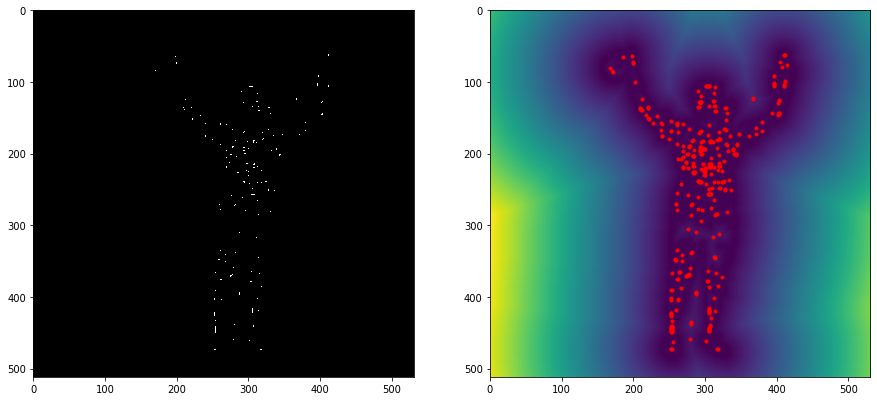

In [21]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)

peak_idx =  feature.peak_local_max(dt, indices=True, min_distance=5)
peak_idx[:5]

f,(ax0,ax1) = plt.subplots(1,2, figsize=(15,10))
ax0.imshow(local_max, cmap='gray')
ax1.plot(peak_idx[:,1], peak_idx[:,0],'r.')
ax1.imshow(dt)

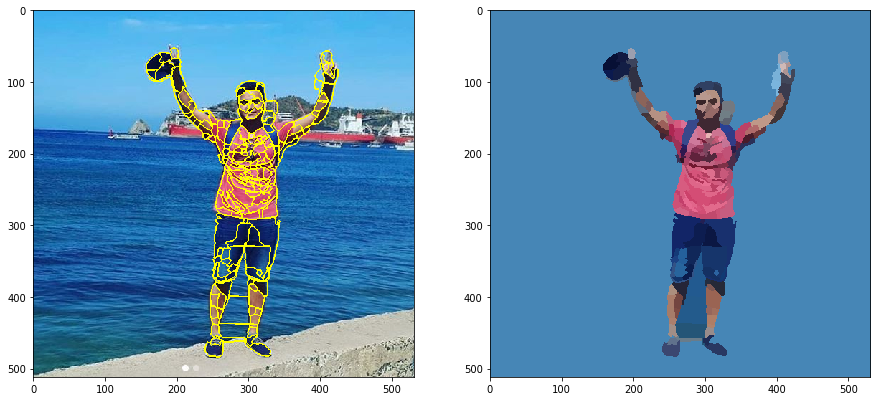

In [22]:
markers = measure.label(local_max)
labels = morphology.watershed(-dt,markers)

f,(ax0,ax1) = plt.subplots(1,2, figsize=(15,10))
ax0.imshow(segmentation.mark_boundaries(img_ori2,labels))
#ax1.imshow(color.label2rgb(labels, image=img_ori))
ax1.imshow(color.label2rgb(labels, image=img_ori2, kind='avg'))

img_label=color.label2rgb(labels, image=img_ori2, kind='avg')

In [23]:
imgRini = img_label[0,0,0]
imgGini = img_label[0,0,1]
imgBini = img_label[0,0,2]

print("%r %r %r" % (imgRini,imgGini,imgBini))

alto=img_label.shape[0]
ancho=img_label.shape[1]
grosor=img_label.shape[2]

img_label2 = img_label.copy()

70 134 182


<Figure size 720x720 with 0 Axes>

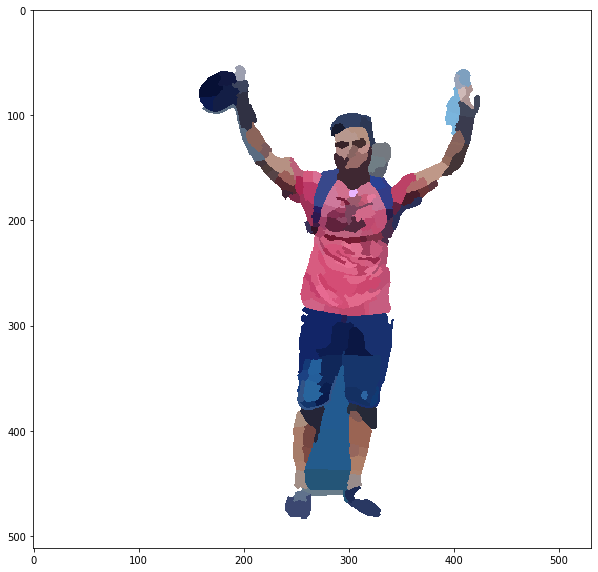

In [24]:

for i in range(alto):
    for j in range(ancho):
        if imgRini == img_label[i,j,0]:
            img_label2[i,j,0] = 255
            
for i in range(alto):
    for j in range(ancho):
        if imgGini == img_label[i,j,1]:
            img_label2[i,j,1] = 255

for i in range(alto):
    for j in range(ancho):
        if imgBini == img_label[i,j,2]:
            img_label2[i,j,2] = 255
                

plt.figure(figsize=(10, 10))
plt.imshow(img_label2)

img_label3 = img_label2.copy()

In [25]:
def euclidean_distance(pointsA,pointsB):
    d = np.sqrt(np.power(pointsB[0]-pointsA[0],2) + np.power(pointsB[1]-pointsA[1],2)) 
    return d

In [26]:
d_hombro_codo=(dist[3,0]+dist[5,0])/2
d_codo_muñeca=(dist[4,0]+dist[6,0])/2
anchura_biacromial=euclidean_distance(dist[1,3:5],dist[2,3:5])

A_points = np.array([dist[3,1:3], pmid[3,:], dist[3,3:5], pmid[4,:]])
B_points = np.array([pmid[3,:], dist[3,3:5], pmid[4,:], dist[4,3:5]])
mid = np.array([pmid[3,:],dist[3,3:5],pmid[4,:],dist[4,3:5]])

A_points.shape
B_points.shape
mid.shape

(4, 2)

(4, 2)

(4, 2)

In [27]:
def perpendicular_slope(pointsA,pointsB):
    offset = 1
    if pointsB[1] == pointsA[1] and pointsB[0] != pointsA[0]:
        slope=(pointsB[1]-pointsA[1]+offset)/(pointsB[0]-pointsA[0]) 
    elif pointsB[1] != pointsA[1] and pointsB[0] == pointsA[0]:
        slope=(pointsB[1]-pointsA[1])/(pointsB[0]-pointsA[0]+offset)
    elif pointsB[1] == pointsA[1] and pointsB[0] == pointsA[0]:
        slope=(pointsB[1]-pointsA[1]+offset)/(pointsB[0]-pointsA[0]+offset)
    else:
        slope=(pointsB[1]-pointsA[1])/(pointsB[0]-pointsA[0])
    per_slope=-1/slope
    return per_slope

In [28]:
def point_on_line(slope,pmid,pnew):
    y = slope*(pnew[0]-pmid[0]) + pmid[1]
    if pnew[1]==y:
        state=True
    else:
        state=False
    return state

In [29]:
def orientation(pointsA,pointsB):
    if pointsA[0] == pointsB[0]: # x iguales
        ind=0
    elif pointsA[1] == pointsB[1]: # y iguales
        ind=1
    elif pointsA[0] > pointsB[0] and pointsA[1] < pointsB[1]: # brazo derecho
        ind=2
    elif pointsB[0] > pointsA[0] and pointsA[1] < pointsB[1]: # brazo izquierdo
        ind=3
    elif pointsA[0] < pointsB[0] and pointsA[1] > pointsB[1]: # brazo derecho arriba
        ind=4
    elif pointsB[0] < pointsA[0] and pointsA[1] > pointsB[1]: # brazo izquierdo arriba
        ind=5
    return ind

In [30]:
offset = 100
radius = 100

p_1 = []
p_2 = []
thick = []

seedValue = random.randrange(5)
random.seed(seedValue)

for i in range(0, mid.shape[0]):
    
    state=orientation(A_points[i],B_points[i])
    p = mid[i]
    if state==0:
        dini=radius
        for m in range(0, offset):
            x1=random.randint(p[0]-radius,p[0])
            y1=random.randint(p[1]-radius,p[1]+radius)
            if img_label3[x1,y1,0] == 255 and img_label3[x1,y1,1] == 255 and img_label3[x1,y1,2] == 255:
                d = np.sqrt(np.power(x1-p[0],2) + np.power(y1-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x1def = x1
                    y1def = y1
                    dend1 = d
        dini=radius
        for m in range(0, offset):
            x2=random.randint(p[0],p[0]+radius)
            y2=random.randint(p[1]-radius,p[1]+radius)
            if img_label3[x2,y2,0] == 255 and img_label3[x2,y2,1] == 255 and img_label3[x2,y2,2] == 255:
                d = np.sqrt(np.power(x2-p[0],2) + np.power(y2-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x2def = x2
                    y2def = y2
                    dend2 = d
        dend=dend1+dend2
    elif state==1:
        dini=radius
        for m in range(0, offset):
            x1=random.randint(p[0]-radius,p[0]+radius)
            y1=random.randint(p[1]-radius,p[1])
            if img_label3[x1,y1,0] == 255 and img_label3[x1,y1,1] == 255 and img_label3[x1,y1,2] == 255:
                d = np.sqrt(np.power(x1-p[0],2) + np.power(y1-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x1def = x1
                    y1def = y1
                    dend1 = d
        dini=radius    
        for m in range(0, offset):
            x2=random.randint(p[0]-radius,p[0]+radius)
            y2=random.randint(p[1],p[1]+radius)
            if img_label3[x2,y2,0] == 255 and img_label3[x2,y2,1] == 255 and img_label3[x2,y2,2] == 255:
                d = np.sqrt(np.power(x2-p[0],2) + np.power(y2-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x2def = x2
                    y2def = y2
                    dend2 = d
        dend=dend1+dend2
    elif state==2:
        dini=radius
        for m in range(0, offset):
            x1=random.randint(p[0]-radius,p[0])
            y1=random.randint(p[1]-radius,p[1])
            if img_label3[x1,y1,0] == 255 and img_label3[x1,y1,1] == 255 and img_label3[x1,y1,2] == 255:
                d = np.sqrt(np.power(x1-p[0],2) + np.power(y1-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x1def = x1
                    y1def = y1
                    dend1 = d
        dini=radius
        for m in range(0, offset):
            x2=random.randint(p[0],p[0]+radius)
            y2=random.randint(p[1],p[1]+radius)
            if img_label3[x2,y2,0] == 255 and img_label3[x2,y2,1] == 255 and img_label3[x2,y2,2] == 255:
                d = np.sqrt(np.power(x2-p[0],2) + np.power(y2-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x2def = x2
                    y2def = y2
                    dend2 = d
        dend=dend1+dend2
    elif state==3:
        dini=radius
        for m in range(0, offset):
            x1=random.randint(p[0],p[0]+radius)
            y1=random.randint(p[1]-radius,p[1])
            if img_label3[x1,y1,0] == 255 and img_label3[x1,y1,1] == 255 and img_label3[x1,y1,2] == 255:
                d = np.sqrt(np.power(x1-p[0],2) + np.power(y1-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x1def = x1
                    y1def = y1
                    dend1 = d
        dini=radius    
        for m in range(0, offset):
            x2=random.randint(p[0]-radius,p[0])
            y2=random.randint(p[1],p[1]+radius)
            if img_label3[x2,y2,0] == 255 and img_label3[x2,y2,1] == 255 and img_label3[x2,y2,2] == 255:
                d = np.sqrt(np.power(x2-p[0],2) + np.power(y2-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x2def = x2
                    y2def = y2
                    dend2 = d
        dend=dend1+dend2
    elif state==4:
        dini=radius
        for m in range(0, offset):
            x1=random.randint(p[0]-radius,p[0])
            y1=random.randint(p[1]-radius,p[1])
            if img_label3[x1,y1,0] == 255 and img_label3[x1,y1,1] == 255 and img_label3[x1,y1,2] == 255:
                d = np.sqrt(np.power(x1-p[0],2) + np.power(y1-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x1def = x1
                    y1def = y1
                    dend1 = d
        dini=radius    
        for m in range(0, offset):
            x2=random.randint(p[0],p[0]+radius)
            y2=random.randint(p[1],p[1]+radius)
            if img_label3[x2,y2,0] == 255 and img_label3[x2,y2,1] == 255 and img_label3[x2,y2,2] == 255:
                d = np.sqrt(np.power(x2-p[0],2) + np.power(y2-p[1],2))
                if d < dini and d > 0:
                    dini = d
                    x2def = x2
                    y2def = y2
                    dend2 = d
        dend=dend1+dend2
    elif state==5:
        dini=radius
        for m in range(0, offset):
            x1=random.randint(p[0],p[0]+radius)
            y1=random.randint(p[1]-radius,p[1])
            if img_label3[x1,y1,0] == 255 and img_label3[x1,y1,1] == 255 and img_label3[x1,y1,2] == 255:
                d = np.sqrt(np.power(x1-p[0],2) + np.power(y1-p[1],2))
                if d < dini:
                    dini = d
                    x1def = x1
                    y1def = y1
                    dend1 = d
        dini=radius    
        for m in range(0, offset):
            x2=random.randint(p[0]-radius,p[0])
            y2=random.randint(p[1],p[1]+radius)
            if img_label3[x2,y2,0] == 255 and img_label3[x2,y2,1] == 255 and img_label3[x2,y2,2] == 255:
                d = np.sqrt(np.power(x2-p[0],2) + np.power(y2-p[1],2))
                if d < dini:
                    dini = d
                    x2def = x2
                    y2def = y2
                    dend2 = d
        dend=dend1+dend2
            
    p_1.append((int(x1def),int(y1def)))
    p_2.append((int(x2def),int(y2def)))
    thick.append(float(dend))
            
p_1 = np.array(p_1)
p_2 = np.array(p_2)
thick = np.array(thick)

In [31]:
perimetro_brazo = math.pi*thick[0]
anchura_del_codo = thick[1]
perimetro_antebrazo = math.pi*thick[2]
anchura_muñeca = thick[3]

In [32]:
print('distacia hombro codo: %.1f' % (d_hombro_codo))
print('distancia codo muñeca: %.1f' % (d_codo_muñeca))
print('anchura biacromial %.1f' % (anchura_biacromial)) 

print('anchura muñeca: %.1f' % (anchura_muñeca))
print('perimetro brazo: %.1f' % (perimetro_brazo))
print('perimetro antebrazo: %.1f' % (perimetro_antebrazo))
print('anchura del codo %.1f' % (anchura_del_codo)) 

distacia hombro codo: 61.0
distancia codo muñeca: 52.5
anchura biacromial 69.0
anchura muñeca: 29.4
perimetro brazo: 25.1
perimetro antebrazo: 47.9
anchura del codo 40.4


In [33]:
factor=0.8

d1=d_hombro_codo*factor
d2=d_codo_muñeca*factor
d3=anchura_muñeca*factor
d4=perimetro_brazo*factor
d5=perimetro_antebrazo*factor
d6=anchura_biacromial*factor
d7=anchura_del_codo*factor

if d1<27:
    d1=27
elif d1>40:
    d1=40  
if d2<20:
    d2=20
elif d2>33:
    d2=33
if d3<4:
    d3=4
elif d3>6:
    d3=6
if d4<23:
    d4=23
elif d4>34:
    d4=34
if d5<20:
    d5=20
elif d5>30:
    d5=30
if d6<32:
    d6=32
elif d6>43:
    d6=43
if d7<5:
    d7=5
elif d7>7:
    d7=7

In [59]:
print('distacia hombro codo: %.1f, distancia doco muñeca: %.1f, anchura muñeca: %.1f' % (d_hombro_codo, d_codo_muñeca, anchura_muñeca))
print('perimetro brazo: %.1f, perimetro antebrazo: %.1f' % (perimetro_brazo, perimetro_antebrazo))
print('anchura biacromial %.1f, anchura del codo %.1f' % (anchura_biacromial, anchura_del_codo)) 
print('valores escalados %.1f, %.1f, %.1f, %.1f, %.1f, %.1f, %.1f' % (d1,d2,d3,d4,d5,d6,d7)) 

distacia hombro codo: 61.0, distancia doco muñeca: 52.5, anchura muñeca: 29.4
perimetro brazo: 25.1, perimetro antebrazo: 47.9
anchura biacromial 69.0, anchura del codo 40.4
valores escalados 40.0, 33.0, 6.0, 23.0, 30.0, 43.0, 7.0
